In [1]:
import os;
import sys;
import random;
import math
import json
import imutils;

import numpy as np;
import cv2;
import matplotlib.pyplot as plt;



import tensorflow as tf
from tensorflow import keras;

from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import roc_curve, auc

from keras import backend as K

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#use keras load the unet model. 

glandModel = tf.keras.models.load_model("gland_unet.hdf5",compile=False);

In [3]:
trainData= "./public_data/trainData";
trainDataList = os.listdir(trainData);

testData = "./public_data/testData";
testDataList = os.listdir(testData);

In [4]:
#random choice an image data
file = random.choice(testDataList)
filepath = testData+"/"+file;

In [5]:
img = filepath+"/crop.png";
img=cv2.imread(img)
saved_result = filepath+"/grayscale.png";
saved_result=cv2.imread(saved_result)

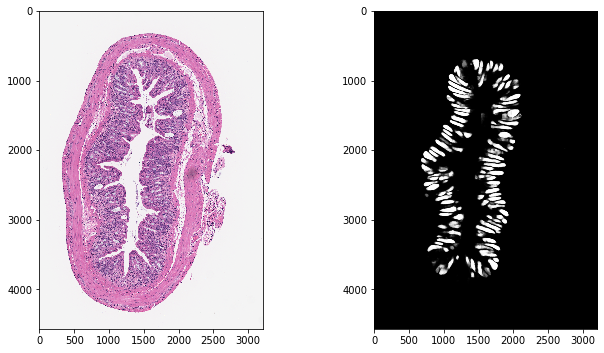

In [6]:
#look my saved predict result
fig = plt.figure(figsize=(10,10));
fig.subplots_adjust(hspace=0.5,wspace=0.5)
ax = fig.add_subplot(1,2,1)
ax.imshow(img[:,:,:])
ax = fig.add_subplot(1,2,2);
ax.imshow(saved_result[:,:])

In [7]:
#predict by code
#set input shape,window move step,remove border. and threshold

step=(300,300)
inputshape=(512,512)
cutborder = 48;
cutoff=210;#int(255*0.85)

In [8]:
def predictLargeImage(image,step,inputshape,cutborder,cutoff):
    
    #split image to tile by input shape and step.
    #save the start location of each image as id.
    w = image.shape[1]
    h = image.shape[0]
    
    x_count = math.ceil((w-int(inputshape[0]) )/float(step[0]))+1
    y_count = math.ceil((h-int(inputshape[1]) )/float(step[1]))+1;


    x_array=[];
    y_array=[];
    for i in range(x_count):
        xindex= int(step[0])*i;

        if xindex+int(inputshape[0]) > w:
            xindex = w-int(inputshape[0]);

        x_array.append(xindex)
    
    for i in range(y_count):
        yindex= int(step[1])*i;
        if yindex+int(inputshape[1]) > h:
            yindex = h-int(inputshape[1]);

        y_array.append(yindex)
    
    ids=[];
    for i in x_array:
        for j in y_array:
            ids.append( [i,j] )
            
            
    final_img=np.zeros((image.shape[0],image.shape[1],1))
    new_img = np.empty((image.shape[0],image.shape[1],1));
    new_img_count = np.zeros((image.shape[0],image.shape[1]));
    
    startXY = ids[0];
    endXY = ids[-1];
    
    #loop saved ids. 
    #get tile by id
    #predict
    #cut the border(high error area)
    #combine all tiles, the overlap area , use mean.
    
    for i in ids:
        temp = image[i[1]: (i[1]+inputshape[1] ), i[0] :  (i[0]+inputshape[0] ) ];
        temp = cv2.normalize(temp, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
        temp =temp/255.0;
        temp = np.asarray([temp]);
        temp = glandModel.predict(temp);
        
        temp = temp[0];
        
        for y in range(len(temp)):
            for x in range(len(temp[y])):

                if i[1] !=startXY[1] and y<cutborder:
                    continue;
                if i[0] !=startXY[0] and x <cutborder:
                    continue;

                if i[0] != endXY[0] and (x+cutborder) > inputshape[0]:
                    continue;
                if i[1] != endXY[1] and (y+cutborder) > inputshape[1]:
                    continue;    


                val=temp[y][x];
                val =np.array(val)
                new_img[i[1]+y][ i[0]+x] =  new_img[i[1]+y][ i[0]+x]+ val  
                new_img_count[i[1]+y][ i[0]+x] +=1
                
                
    for y in range(len(final_img)):
        for x in range(len(final_img[y])):
            final_img[y][x]= np.array(new_img[y][x])/int(new_img_count[y][x]);
            
    final_img =  np.asarray(final_img*255 , dtype=np.uint8)        
    ret, binary = cv2.threshold(final_img,cutoff,255,cv2.THRESH_BINARY)        
    
    
    #return predict result, 
    return final_img ,binary

In [9]:
result,result_binary = predictLargeImage(img,step,inputshape,cutborder,cutoff)

In [21]:
result=np.asarray(result)
result = result.reshape((result.shape[0],result.shape[1]))

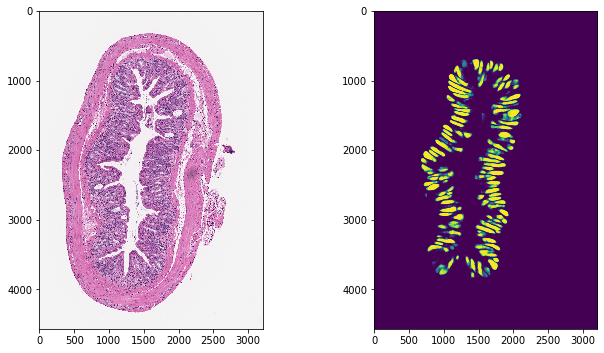

In [23]:
fig = plt.figure(figsize=(10,10));
fig.subplots_adjust(hspace=0.5,wspace=0.5)
ax = fig.add_subplot(1,2,1)
ax.imshow(img[:,:,:])
ax = fig.add_subplot(1,2,2);
ax.imshow(result[:,:])